# KNN Regressor
The KNN regressor algorithm is used to predic a continuous variable for sample based on number of nearest neighbors.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np


from utils import shuffle, train_test_split, min_max_normalize, mean_absolute_error, mean_squared_error, root_mean_squared_error, one_hot_encoder
from utils.math_functions import euclidian_distance

from neighbors import KNNRegressor

In [2]:
np.random.seed(1234)

In [3]:
auto_mpg = pd.read_csv('./data/auto-mpg.csv')
auto_mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
auto_mpg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [5]:
auto_mpg.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

# Preparing the datasets
* Data Cleaning
* One Hot Encode
* Train Test split
* Normalize

## Data Cleaning

The column 'car name' has no predictive value and will be removed from dataset

The 'horsepower' column has missing values ​​that will be removed

In [6]:
auto_mpg.pop('car name')

auto_mpg = auto_mpg[auto_mpg['horsepower'] != '?']
auto_mpg['horsepower'] = auto_mpg['horsepower'].astype(int)


## One Hot Encode
One hot encoder will create a matrix n x m where n is the number of rows, and m represents the labels. the number 1 indicates the observation label (line) EX:

```py
values = ['A', 'B', 'B', 'C', 'A']
onehot = [
    [1, 0, 0], # Representation of label 'A'
    [0, 1, 0], # Representation of label 'B'
    [0, 1, 0], # Representation of label 'B'
    [0, 0, 1], # Representation of label 'C'
    [1, 0, 0], # Representation of label 'A'
]
```

For most algorithms, not to mention all, it is important to convert categorical features into one hot encode, as the algorithm will consider that one label is more relevant than the other, that is, 'C' is greater than 'A' if you just convert to a integer.

KNN uses distance to make predictions. In this case if we directly convert the labels to an integer, the distance from A may be greater than from C, and the calculation will be wrong.

In [7]:
one_hot = pd.DataFrame(one_hot_encoder(auto_mpg['origin']), columns=['origin_1', 'origin_2', 'origin_3'])
print(len(one_hot), len(auto_mpg))
auto_mpg = pd.concat([auto_mpg.reset_index(drop=True), one_hot.reset_index(drop=True)], axis=1)
auto_mpg.iloc[20:30]

392 392


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,origin_1,origin_2,origin_3
20,25.0,4,110.0,87,2672,17.5,70,2,0.0,1.0,0.0
21,24.0,4,107.0,90,2430,14.5,70,2,0.0,1.0,0.0
22,25.0,4,104.0,95,2375,17.5,70,2,0.0,1.0,0.0
23,26.0,4,121.0,113,2234,12.5,70,2,0.0,1.0,0.0
24,21.0,6,199.0,90,2648,15.0,70,1,1.0,0.0,0.0
25,10.0,8,360.0,215,4615,14.0,70,1,1.0,0.0,0.0
26,10.0,8,307.0,200,4376,15.0,70,1,1.0,0.0,0.0
27,11.0,8,318.0,210,4382,13.5,70,1,1.0,0.0,0.0
28,9.0,8,304.0,193,4732,18.5,70,1,1.0,0.0,0.0
29,27.0,4,97.0,88,2130,14.5,71,3,0.0,0.0,1.0


In [8]:
train, test = train_test_split(auto_mpg, train_size=0.7)

x_train = train.drop('mpg', axis=1)
x_test = test.drop('mpg', axis=1)

y_train = train['mpg']
y_test = test['mpg']

In [9]:
x_train, minmax = min_max_normalize(x_train)
x_test, _ = min_max_normalize(x_test)

x_test =x_test.fillna(0)
x_test.describe()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,origin_1,origin_2,origin_3
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,0.455932,0.323513,0.347681,0.389792,0.483984,0.497175,0.292373,0.627119,0.161017,0.211864
std,0.327524,0.276548,0.230849,0.248015,0.222040,0.309115,0.409952,0.485633,0.369114,0.410372
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.083102,0.177632,0.189856,0.349576,0.250000,0.000000,0.000000,0.000000,0.000000
50%,0.200000,0.199446,0.299342,0.331239,0.466102,0.500000,0.000000,1.000000,0.000000,0.000000
75%,0.600000,0.504155,0.407895,0.548175,0.652542,0.750000,0.500000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## KNN explanation
It is recommended to see the full algorithm in neighbors/knn_regressor.py

## Train
The training of knn consists only to saving the training dataset, like KNN Classifier (1_knn_classifier.ipynb).


In [10]:
k = 3 # always defined on class constructor
x = np.array(x_train.values.tolist())
y = np.array(y_train.values.tolist())

## Predict

To predict a sample, you must find the k nearest neighbors like knn classifer, and calculate the mean of them. The result of mean, is the predicted value.

The prediction consists of these steps
* Calculate distances between the sample and the training dataset
* Sort the distances ascending
* Select the k lowest distances
* Select the y values of each distances
* Calculate the result

The result can be calculated using the average, or the weighted average, for example.

In [11]:
sample = x_test.iloc[0].tolist()
y_sample = y_test.iloc[0].tolist()
y_true = y_test.iloc[0]

In [12]:
distances = euclidian_distance(sample, x)
distances[:15]

array([1.95840793, 1.67996186, 1.65638175, 1.53387625, 1.53042631,
       1.50704939, 1.6683583 , 1.5403874 , 2.24980341, 1.58992928,
       1.5077562 , 1.64514958, 0.43335542, 1.53294103, 0.46495855])

In [13]:
# argsort retun the indices that sort the distance array 
index = np.argsort(distances)

# Select the k lowest distances index
k_best_index = index[:k]

# Select the labels of each distances
k_best = y[k_best_index]

# Calculate the result using mean
y_pred = np.mean(k_best)

print(k_best)

[25. 28. 24.]


In [14]:
print('y_pred:', y_pred)
print('y_true:', y_true)
print('error:', y_true - y_pred)

y_pred: 25.666666666666668
y_true: 25.0
error: -0.6666666666666679


# KNN Regressor Model

In [15]:
def show_error(y_pred):
    print('mae:', mean_absolute_error(y_pred, y_test))
    print('mse:', mean_squared_error(y_pred, y_test))
    print('rmse:', root_mean_squared_error(y_pred, y_test))

In [16]:
knn = KNNRegressor(k=4, mode='mean')
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)
show_error(y_pred)

mae: 2.0383474576271188
mse: 9.745344279661019
rmse: 3.1217533982781247


In [17]:
knn = KNNRegressor(k=4, mode='weight')
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)
show_error(y_pred)

mae: 2.0535648410431677
mse: 9.835781967242598
rmse: 3.1362050263403694


## Finding Best K

besk k:4	7.76
Wall time: 70.8 ms


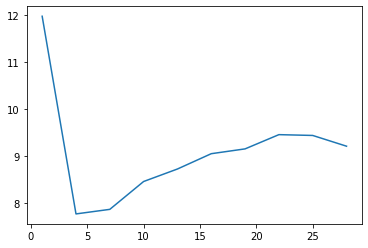

In [18]:
%%time
knn = KNNRegressor(k=1, mode='mean')
knn.fit(x_train, y_train)

hist = []
for k in range(1, 30, 3):
    knn.k = k
    y_pred = knn.predict(y_test)
    rmse =mean_absolute_error(y_pred, y_test)
    hist.append([k, rmse])

hist = np.array(hist)
sns.lineplot(x = hist[:, 0], y= hist[:, 1])
best =  hist[np.argmin(hist[:, 1])]
print('besk k:%d\t%.2f'%(int(best[0]), best[1]))

besk k:4	7.76
Wall time: 83.8 ms


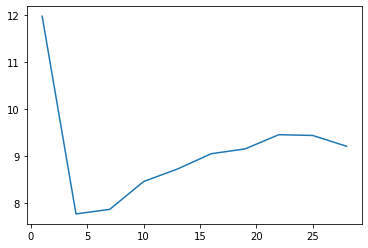

In [19]:
%%time
knn = KNNRegressor(k=1, mode='weight')
knn.fit(x_train, y_train)

hist = []
for k in range(1, 30, 3):
    knn.k = k
    y_pred = knn.predict(y_test)
    rmse =  mean_absolute_error(y_pred, y_test)
    hist.append([k, rmse])

hist = np.array(hist)
sns.lineplot(x = hist[:, 0], y= hist[:, 1])

best =  hist[np.argmin(hist[:, 1])]
print('besk k:%d\t%.2f'%(int(best[0]), best[1]))